# Dynamic Frame Generation Using Machine Learning and Scene Data

This notebook holds my OpenCV code for preprocessing frameblocks. A frameblock is a section of an input image that I will use for later image processing and Machine Learning training. The correct calculation of frameblocks is important, since the machine learning algorithm may over-train or under-train if given poor training images.

In [1]:
import os as os
import cv2 as cv2
import numpy as np
from matplotlib import pyplot as plt

block_dim = 32
block_offset = 1

## Frame Preprocessing

#### Animation source:
  * https://www.youtube.com/watch?v=AJWfhr29vBg

#### What to process:
  * We can't use an entire frame as inputs for a ML algorithm
  * Must decide what portions of an image to use as frameblocks
    * Input: 2 images
    * Output: all frameblocks which meet our image processing requirements

#### Global Methodology:
  * Process every frame with its neighbors
  * Left neighbor will have already been calculated in the previous step
  * Capture all frame blocks showing changes

### Image processing initialization.

Read in the frames and process them.

Below the two images are plotted side by side, as a reminder of how different they appear. In theory these images should be two consecutive frames, which usually means they will have very small differences.

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

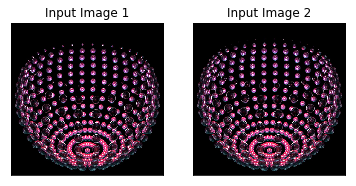

In [2]:
# Initialize seed variables.
img_str_1 = './images/samples/frame_1_complex.jpg'
img_str_2 = './images/samples/frame_3_complex.jpg'
img_str_out = './images/output_complex.jpg'
img_str_roi = './images/frameblock_roi_complex.jpg'

# Delete previously found shadows, frames and buffers are deleted later.
os.system('rm -rf %s' % './images/blocks/buffer/shadows/')
os.mkdir('./images/blocks/buffer/shadows/')

img_1 = cv2.cvtColor(cv2.imread(img_str_1), cv2.COLOR_BGR2RGB)
height_1, width_1 = img_1.shape[:2]
img_2 = cv2.cvtColor(cv2.imread(img_str_2), cv2.COLOR_BGR2RGB)
height_2, width_2 = img_2.shape[:2]

# Choose smallest boundaries.
height = height_1
width = width_1
if height_1 > height_2:
    height = height_2
if width_1 > width_2:
    width = width_2

# Plot images for reference.
plt.subplot(121),plt.imshow(img_1),plt.title('Input Image 1')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_2),plt.title('Input Image 2')
plt.xticks([]), plt.yticks([])

### Shadow Image Creation
  
#### Goal:
  * Find the difference between the two input images to measure change
  * Called the "Shadow Image" for the two inputs

#### Mathematical Definition:
  * Let $p_i(x,y)$ be the pixel at coordinate $(x,y)$ for image $i$
  * Let $\oplus$ represent the XOR operation.
  * Calculate the following value:

$$P(x,y) = p_1(x,y) \oplus p_2(x,y)$$

  * Store this as the value for the output image.
  
#### Pixels of the output image are processed:
  * We want to find the capped sum of pixel values:
    * Summation of pixel values
    * Each pixel adds it's red, green, and blue (RGB) values together
    * Caps the value at 255
  * We use this value later to calculate ratio of black pixels

Below is the calculated output image. This image graphically shows the differences between frames, where white represents no difference and black represents the maximal difference. We are able to use this later to calculate frameblocks.

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

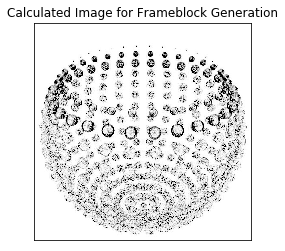

In [3]:
img_out = np.ones((height, width, 3), np.uint8)
total_pixel_sum = 0

# Loop through each pixel.
for y in range(0, height):
    for x in range(0, width):
        #print(img_sample_1[y, x], img_sample_2[y, x])
        pixel_out = abs(img_1[y, x] ^ img_2[y, x])
        #print(pixel_out)
        pixel_sum = int(pixel_out[0]) + int(pixel_out[1]) + int(pixel_out[2])
        if pixel_sum > 255:
            bw_val = 255
        else:
            bw_val = np.uint8(pixel_sum)
        total_pixel_sum += bw_val
        bw_val = 255 - bw_val
        img_out[y, x] = bw_val

# Write image and plot to screen.
cv2.imwrite(img_str_out, img_out)
plt.subplot(111),plt.imshow(img_out),plt.title('Calculated Image for Frameblock Generation')
plt.xticks([]), plt.yticks([])

### Frameblock Selection

#### Using the above calculated image.
  * Selected based on the percentage of black pixels
    * % = total sum of pixel values in the shadow image divided by how many black pixels are possible in the image 
    * I.e. the probability of encountering a changed pixel
  * Why can't we just use a set ratio?
    * Proven inaccurate through testing.

#### Method:
  * Sliding window
  * Able to change the overlap
  * How does overlap affect training?
    * Time
    * Efficiency
    * This trade-off will need further testing

#### Results:
  * Input dimensions:
    * 512 x 512 pixel input frame
    * 32 x 32 pixel frameblocks
    * No overlap (can be modified)
  * Thus 256 frameblocks per frame possible
    * On average 128 generated
  * Show where the frameblock originated for discussion

Each frameblock selected is saved to an image file. A red rectangle is also overlaid on top of the original calculated image to represent where each frameblock was selected from. Frameblocks which are found to not show enough changes to be included in this iteration are used to find differences spanning multiple frames (described later).

In [4]:
# Calculate the pixel_ratio.
print("Total pixel sum: " + str(total_pixel_sum))
pixel_ratio = total_pixel_sum * 1.0 / (255 * width * height)
print("Pixel ratio: " + str(pixel_ratio))

# Create a clone of input image and draw ROIs on top of it.
img_roi_all = cv2.imread(img_str_out)

# Create sliding window.
left = 0
right = block_dim
top = 0
bottom = block_dim
frame_index = 1
pixel_sum = 0
cap = np.power(block_dim, 2) * 255 * pixel_ratio
print("Cap found: " + str(cap))

# Delete previously found frames and buffers.
os.system('rm -rf %s' % './images/blocks/complex/')
os.mkdir('./images/blocks/complex/')
os.system('rm -rf %s' % './images/blocks/buffer/frames/')
os.mkdir('./images/blocks/buffer/frames/')

# Find the Region Of Interest (ROI).
while bottom <= height:
    if bottom == height:
        bottom -= 1
    while right <= width:
        if right == width:
            right -= 1
        found_x = False
        dirty = False
        pixel_sum = 0
        img_buff_str = './images/blocks/buffer/shadows/block' + str(frame_index) + '.jpg'
        img_buff = cv2.imread(img_buff_str)
        if img_buff is None:
            img_buff = np.zeros((block_dim, block_dim, 3), np.uint8)
        
        # ROI pixel processing
        for y in range(top, bottom + 1):
            for x in range(left, right + 1):
                # Store buffer pixel and calculate pixel_sum.
                img_buff[y - top - 1, x - left - 1] += 255 - img_out[y, x]
                if img_buff[y - top - 1, x - left - 1][0] > 0:
                    dirty = True
                    if img_buff[y - top - 1, x - left - 1][0] > 255:
                        img_buff[y - top - 1, x - left - 1] = 255
                pixel_sum += img_buff[y - top - 1, x - left - 1][0]
                
                # Test if the cap was met.
                if pixel_sum >= cap:
                    # Draw Blcok ROI on clone image.
                    cv2.rectangle(img_roi_all, (left + 1, top + 1), (right - 1, bottom - 1), (255, 0, 0), 1)
                    print(str(frame_index) + ". Sum: " + str(pixel_sum) + ", Frameblock: (" + str(left) + ", " + str(top) + "), (" + str(right) + ", " + str(bottom) + "))")
                    
                    # Store window contents as image.
                    img_roi_1 = img_1[top:bottom, left:right]
                    img_roi_2 = img_2[top:bottom, left:right]
                    cv2.imwrite('./images/blocks/complex/block' + str(frame_index) + '_1.jpg', cv2.cvtColor(img_roi_1, cv2.COLOR_RGB2BGR))
                    cv2.imwrite('./images/blocks/complex/block' + str(frame_index) + '_2.jpg', cv2.cvtColor(img_roi_2, cv2.COLOR_RGB2BGR))
                    
                    # Exit both for loops.
                    found_x = True
                    break
                else:
                    # Draw Shadow ROI on clone image.
                    cv2.rectangle(img_roi_all, (left + 1, top + 1), (right - 1, bottom - 1), (0, 0, 255), 1)
            if found_x:
                break
        # If frameblock was used delete buffer file, else export buffer and frame ROI's.
        if found_x:
            if os.path.exists(img_buff_str):
                os.remove(img_buff_str)
        else:
            cv2.imwrite(img_buff_str, img_buff)
            img_buff_str = './images/blocks/buffer/frames/block' + str(frame_index) + '_1.jpg'
            if not os.path.exists(img_buff_str):
                img_roi_buff = img_1[top:bottom, left:right]
                cv2.imwrite(img_buff_str, img_roi_buff)
            img_buff_str = './images/blocks/buffer/frames/block' + str(frame_index) + '_2.jpg'
            if not os.path.exists(img_buff_str):
                img_roi_buff = img_2[top:bottom, left:right]
                cv2.imwrite(img_buff_str, img_roi_buff)
            
            # Update Shadow image or store a new one.
            img_buff_str = './images/blocks/buffer/shadows/block' + str(frame_index) + '.jpg'
            if os.path.exists(img_buff_str):
                img_prev_buff = cv2.imread(img_buff_str)
                cv2.addWeighted(img_prev_buff, 1.0, img_buff, 1.0, 0.0, img_buff)
                cv2.imwrite(img_buff_str, img_buff)
            elif dirty:
                cv2.imwrite(img_buff_str, img_buff)
            
        frame_index += 1
        
        # Shift horizontally
        left += int(block_dim / block_offset)
        right += int(block_dim / block_offset)
    # Shift vertically
    top += int(block_dim / block_offset)
    bottom += int(block_dim / block_offset)
    left = 0
    right = block_dim

Total pixel sum: 7813675
Pixel ratio: 0.11688943002738204
Cap found: 30522.16796875
37. Sum: 30544, Frameblock: (128, 64), (160, 96))
38. Sum: 30534, Frameblock: (160, 64), (192, 96))
39. Sum: 30581, Frameblock: (192, 64), (224, 96))
40. Sum: 30552, Frameblock: (224, 64), (256, 96))
41. Sum: 30693, Frameblock: (256, 64), (288, 96))
42. Sum: 30539, Frameblock: (288, 64), (320, 96))
43. Sum: 30537, Frameblock: (320, 64), (352, 96))
44. Sum: 30752, Frameblock: (352, 64), (384, 96))
51. Sum: 30752, Frameblock: (64, 96), (96, 128))
52. Sum: 30609, Frameblock: (96, 96), (128, 128))
53. Sum: 30645, Frameblock: (128, 96), (160, 128))
54. Sum: 30539, Frameblock: (160, 96), (192, 128))
55. Sum: 30542, Frameblock: (192, 96), (224, 128))
56. Sum: 30664, Frameblock: (224, 96), (256, 128))
57. Sum: 30524, Frameblock: (256, 96), (288, 128))
58. Sum: 30615, Frameblock: (288, 96), (320, 128))
59. Sum: 30636, Frameblock: (320, 96), (352, 128))
60. Sum: 30750, Frameblock: (352, 96), (384, 128))
61. Sum: 

The image with the overlaid frameblock areas is shown below.

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

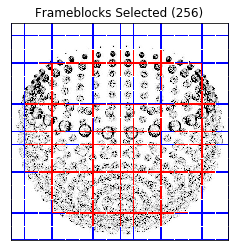

In [5]:
cv2.imwrite(img_str_roi, cv2.cvtColor(img_roi_all, cv2.COLOR_BGR2RGB))
plt.subplot(111),plt.imshow(img_roi_all),plt.title('Frameblocks Selected (' + str(frame_index - 1) + ')')
plt.xticks([]), plt.yticks([])

Some of the generated frameblocks are shown below. Notice the visual differences between them; these frames were marked as different enough to be used as frameblocks for later training.

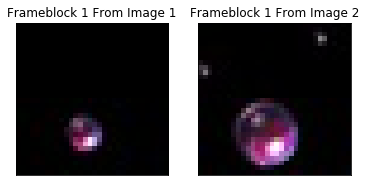

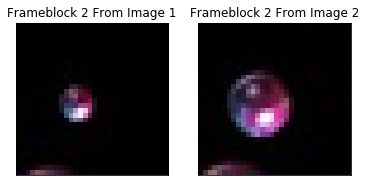

In [6]:
frame_index = 1
img_block_str = './images/blocks/complex/block' + str(frame_index) + '_1.jpg'
while not os.path.exists(img_block_str):
    frame_index += 1
    img_block_str = './images/blocks/complex/block' + str(frame_index) + '_1.jpg'
img_block_1 = cv2.cvtColor(cv2.imread(img_block_str), cv2.COLOR_BGR2RGB)
img_block_str = './images/blocks/complex/block' + str(frame_index) + '_2.jpg'
img_block_2 = cv2.cvtColor(cv2.imread(img_block_str), cv2.COLOR_BGR2RGB)

plt.subplot(121),plt.imshow(img_block_1),plt.title('Frameblock 1 From Image 1')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_block_2),plt.title('Frameblock 1 From Image 2')
plt.xticks([]), plt.yticks([])
plt.show()

frame_index += 1
img_block_str = './images/blocks/complex/block' + str(frame_index) + '_1.jpg'
while not os.path.exists(img_block_str):
    frame_index += 1
    img_block_str = './images/blocks/complex/block' + str(frame_index) + '_1.jpg'
img_block_1 = cv2.cvtColor(cv2.imread(img_block_str), cv2.COLOR_BGR2RGB)
img_block_str = './images/blocks/complex/block' + str(frame_index) + '_2.jpg'
img_block_2 = cv2.cvtColor(cv2.imread(img_block_str), cv2.COLOR_BGR2RGB)

plt.subplot(121),plt.imshow(img_block_1),plt.title('Frameblock 2 From Image 1')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_block_2),plt.title('Frameblock 2 From Image 2')
plt.xticks([]), plt.yticks([])
plt.show()

### Buffer Frameblocks

#### Failed blocks:
  * Stored in 2 formats:
    1. Inverted shadow image file
    2. Frame image file
  * Shadow image file is the ROI of the original shadow image, added together with any previous buffered frameblocks

Each frameblock is not only a comparison between the current and next frames, but instead a comparison of all the frames which didn't pass before

#### Motivations:
  * Gradual changes can be captured (using frame image file and current frame)
  * Only frameblocks that never change will be excluded from the dataset

An example pair of inverted shadow and frame buffer images is shown below.

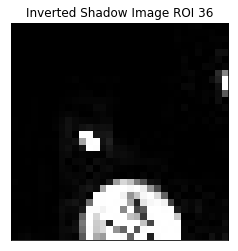

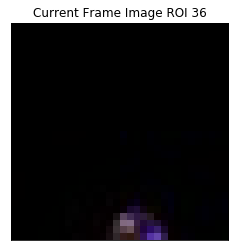

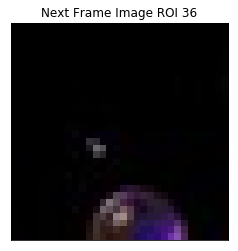

In [7]:
frame_index = 1
while True:
    img_block_str = './images/blocks/buffer/shadows/block' + str(frame_index) + '.jpg'
    while not os.path.exists(img_block_str):
        if frame_index > block_dim * block_dim:
            print('ERROR: No files found!')
            break;
        frame_index += 1
        img_block_str = './images/blocks/buffer/shadows/block' + str(frame_index) + '.jpg'
    if frame_index > block_dim * block_dim:
        print('ERROR: No files found!')
        break
    img_block_1 = cv2.cvtColor(cv2.imread(img_block_str), cv2.COLOR_BGR2RGB)
    
    # Check if image is too black, we want to show a good example.
    rejected = False
    pixel_sum = 0
    cap = np.power(block_dim, 2) * 255 * 0.95
    for y in range(0, block_dim):
        for x in range(0, block_dim):
            pixel_sum += 255 - img_block_1[y, x][0]
            if pixel_sum >= cap:
                rejected = True
                break
        if rejected:
            break
    # Store buffered frame block.
    if not rejected:
        break
    frame_index += 1
    
if frame_index <= block_dim * block_dim:
    img_block_str = './images/blocks/buffer/frames/block' + str(frame_index) + '_1.jpg'
    img_block_2 = cv2.cvtColor(cv2.imread(img_block_str), cv2.COLOR_BGR2RGB)
    img_block_str = './images/blocks/buffer/frames/block' + str(frame_index) + '_2.jpg'
    img_block_3 = cv2.cvtColor(cv2.imread(img_block_str), cv2.COLOR_BGR2RGB)

    plt.subplot(111),plt.imshow(img_block_1),plt.title('Inverted Shadow Image ROI ' + str(frame_index))
    plt.xticks([]), plt.yticks([])
    plt.show()
    plt.subplot(111),plt.imshow(img_block_2),plt.title('Current Frame Image ROI ' + str(frame_index))
    plt.xticks([]), plt.yticks([])
    plt.show()
    plt.subplot(111),plt.imshow(img_block_3),plt.title('Next Frame Image ROI ' + str(frame_index))
    plt.xticks([]), plt.yticks([])
    plt.show()

## Data Analysis

#### How can we measure correctness for these frameblocks?
  * Compare these outputs to a different scene
    * Previous scene is much more complex than we might have realized before
    * Each sphere is:
      * Transparent
      * Very reflective
      * Changes to one sphere impact changes to all the spheres in the scene

The process used above is repeated below, but for spheres that are completely opaque and diffuse; thus the algorithm is able to filter out more data and choose only frameblocks which change between the two frames.

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

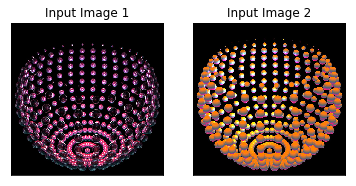

In [8]:
img_str_2 = './images/samples/frame_3_simple.jpg'
img_2 = cv2.cvtColor(cv2.imread(img_str_2), cv2.COLOR_BGR2RGB)
# Plot images for reference.
plt.subplot(121),plt.imshow(img_1),plt.title('Input Image 1')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_2),plt.title('Input Image 2')
plt.xticks([]), plt.yticks([])

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

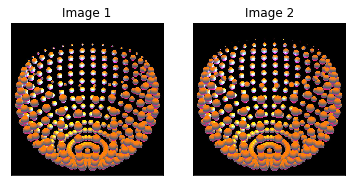

In [9]:
# Reinitialize seed variables.
img_str_1 = './images/samples/frame_1_simple.jpg'
img_str_2 = './images/samples/frame_3_simple.jpg'
img_str_out = './images/output_simple.jpg'
img_str_roi = './images/frameblock_roi_simple.jpg'

# Delete previously found shadows, frames and buffers are deleted later.
os.system('rm -rf %s' % './images/blocks/buffer/shadows/')
os.mkdir('./images/blocks/buffer/shadows/')

img_1 = cv2.cvtColor(cv2.imread(img_str_1), cv2.COLOR_BGR2RGB)
height_1, width_1 = img_1.shape[:2]
img_2 = cv2.cvtColor(cv2.imread(img_str_2), cv2.COLOR_BGR2RGB)
height_2, width_2 = img_2.shape[:2]

# Choose smallest boundaries.
height = height_1
width = width_1
if height_1 > height_2:
    height = height_2
if width_1 > width_2:
    width = width_2

plt.subplot(121),plt.imshow(img_1),plt.title('Image 1')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_2),plt.title('Image 2')
plt.xticks([]), plt.yticks([])

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

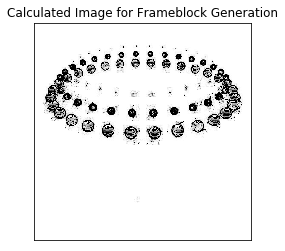

In [10]:
img_out = np.ones((height, width, 3), np.uint8)
total_pixel_sum = 0

# Loop through each pixel.
for y in range(0, height):
    for x in range(0, width):
        #print(img_sample_1[y, x], img_sample_2[y, x])
        pixel_out = abs(img_1[y, x] ^ img_2[y, x])
        #print(pixel_out)
        pixel_sum = int(pixel_out[0]) + int(pixel_out[1]) + int(pixel_out[2])
        if pixel_sum > 255:
            bw_val = 255
        else:
            bw_val = np.uint8(pixel_sum)
        total_pixel_sum += bw_val
        bw_val = 255 - bw_val
        img_out[y, x] = bw_val

cv2.imwrite(img_str_out,img_out)
plt.subplot(111),plt.imshow(img_out),plt.title('Calculated Image for Frameblock Generation')
plt.xticks([]), plt.yticks([])

In [11]:
# Calculate the pixel_ratio.
print("Total pixel sum: " + str(total_pixel_sum))
pixel_ratio = total_pixel_sum * 1.0 / (255 * width * height)
print("Pixel ratio: " + str(pixel_ratio))

# Create a clone of input image and draw ROIs on top of it.
img_roi_all = cv2.imread(img_str_out)

# Create sliding window.
left = 0
right = block_dim
top = 0
bottom = block_dim
frame_index = 1
pixel_sum = 0
cap = np.power(block_dim, 2) * 255 * pixel_ratio
print("Cap found: " + str(cap))

# Delete previously found frames and buffers.
os.system('rm -rf %s' % './images/blocks/simple/')
os.mkdir('./images/blocks/simple/')
os.system('rm -rf %s' % './images/blocks/buffer/frames/')
os.mkdir('./images/blocks/buffer/frames/')

# Find the Region Of Interest (ROI).
while bottom <= height:
    if bottom == height:
        bottom -= 1
    while right <= width:
        if right == width:
            right -= 1
        found_x = False
        dirty = False
        pixel_sum = 0
        img_buff_str = './images/blocks/buffer/shadows/block' + str(frame_index) + '.jpg'
        img_buff = cv2.imread(img_buff_str)
        if img_buff is None:
            img_buff = np.zeros((block_dim, block_dim, 3), np.uint8)
        
        # ROI pixel processing
        for y in range(top, bottom + 1):
            for x in range(left, right + 1):
                # Store buffer pixel and calculate pixel_sum.
                img_buff[y - top - 1, x - left - 1] += 255 - img_out[y, x]
                if img_buff[y - top - 1, x - left - 1][0] > 0:
                    dirty = True
                    if img_buff[y - top - 1, x - left - 1][0] > 255:
                        img_buff[y - top - 1, x - left - 1] = 255
                pixel_sum += img_buff[y - top - 1, x - left - 1][0]
                
                # Test if the cap was met.
                if pixel_sum >= cap:
                    # Draw Blcok ROI on clone image.
                    cv2.rectangle(img_roi_all, (left + 1, top + 1), (right - 1, bottom - 1), (255, 0, 0), 1)
                    print(str(frame_index) + ". Sum: " + str(pixel_sum) + ", Frameblock: (" + str(left) + ", " + str(top) + "), (" + str(right) + ", " + str(bottom) + "))")
                    
                    # Store window contents as image.
                    img_roi_1 = img_1[top:bottom, left:right]
                    img_roi_2 = img_2[top:bottom, left:right]
                    cv2.imwrite('./images/blocks/simple/block' + str(frame_index) + '_1.jpg', cv2.cvtColor(img_roi_1, cv2.COLOR_RGB2BGR))
                    cv2.imwrite('./images/blocks/simple/block' + str(frame_index) + '_2.jpg', cv2.cvtColor(img_roi_2, cv2.COLOR_RGB2BGR))
                    
                    # Exit both for loops.
                    found_x = True
                    break
                else:
                    # Draw Shadow ROI on clone image.
                    cv2.rectangle(img_roi_all, (left + 1, top + 1), (right - 1, bottom - 1), (0, 0, 255), 1)
            if found_x:
                break
        # If frameblock was used delete buffer file, else export buffer and frame ROI's.
        if found_x:
            if os.path.exists(img_buff_str):
                os.remove(img_buff_str)
        else:
            cv2.imwrite(img_buff_str, img_buff)
            img_buff_str = './images/blocks/buffer/frames/block' + str(frame_index) + '_1.jpg'
            if not os.path.exists(img_buff_str):
                img_roi_buff = img_1[top:bottom, left:right]
                cv2.imwrite(img_buff_str, img_roi_buff)
            img_buff_str = './images/blocks/buffer/frames/block' + str(frame_index) + '_2.jpg'
            if not os.path.exists(img_buff_str):
                img_roi_buff = img_2[top:bottom, left:right]
                cv2.imwrite(img_buff_str, img_roi_buff)
            
            # Update Shadow image or store a new one.
            img_buff_str = './images/blocks/buffer/shadows/block' + str(frame_index) + '.jpg'
            if os.path.exists(img_buff_str):
                img_prev_buff = cv2.imread(img_buff_str)
                cv2.addWeighted(img_prev_buff, 1.0, img_buff, 1.0, 0.0, img_buff)
                cv2.imwrite(img_buff_str, img_buff)
            elif dirty:
                cv2.imwrite(img_buff_str, img_buff)
            
        frame_index += 1
        
        # Shift horizontally
        left += int(block_dim / block_offset)
        right += int(block_dim / block_offset)
    # Shift vertically
    top += int(block_dim / block_offset)
    bottom += int(block_dim / block_offset)
    left = 0
    right = block_dim

Total pixel sum: 4546396
Pixel ratio: 0.06801225250842524
Cap found: 17759.359375
36. Sum: 17881, Frameblock: (96, 64), (128, 96))
37. Sum: 17763, Frameblock: (128, 64), (160, 96))
38. Sum: 17992, Frameblock: (160, 64), (192, 96))
39. Sum: 17940, Frameblock: (192, 64), (224, 96))
40. Sum: 17763, Frameblock: (224, 64), (256, 96))
41. Sum: 17802, Frameblock: (256, 64), (288, 96))
42. Sum: 17914, Frameblock: (288, 64), (320, 96))
43. Sum: 17856, Frameblock: (320, 64), (352, 96))
44. Sum: 17883, Frameblock: (352, 64), (384, 96))
45. Sum: 17873, Frameblock: (384, 64), (416, 96))
51. Sum: 17997, Frameblock: (64, 96), (96, 128))
52. Sum: 17860, Frameblock: (96, 96), (128, 128))
53. Sum: 18000, Frameblock: (128, 96), (160, 128))
54. Sum: 17839, Frameblock: (160, 96), (192, 128))
55. Sum: 17761, Frameblock: (192, 96), (224, 128))
56. Sum: 17768, Frameblock: (224, 96), (256, 128))
57. Sum: 17781, Frameblock: (256, 96), (288, 128))
58. Sum: 17895, Frameblock: (288, 96), (320, 128))
59. Sum: 17849

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

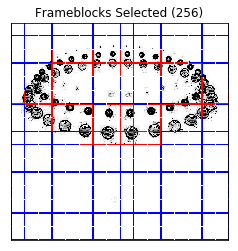

In [12]:
cv2.imwrite(img_str_roi, cv2.cvtColor(img_roi_all, cv2.COLOR_BGR2RGB))
plt.subplot(111),plt.imshow(img_roi_all),plt.title('Frameblocks Selected (' + str(frame_index - 1) + ')')
plt.xticks([]), plt.yticks([])

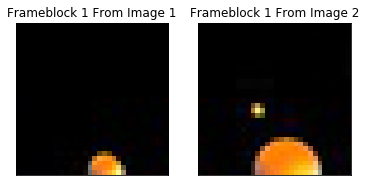

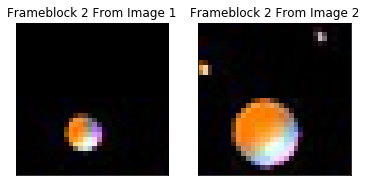

In [13]:
frame_index = 1
img_block_str = './images/blocks/simple/block' + str(frame_index) + '_1.jpg'
while not os.path.exists(img_block_str):
    frame_index += 1
    img_block_str = './images/blocks/simple/block' + str(frame_index) + '_1.jpg'
img_block_1 = cv2.cvtColor(cv2.imread(img_block_str), cv2.COLOR_BGR2RGB)
img_block_str = './images/blocks/simple/block' + str(frame_index) + '_2.jpg'
img_block_2 = cv2.cvtColor(cv2.imread(img_block_str), cv2.COLOR_BGR2RGB)

plt.subplot(121),plt.imshow(img_block_1),plt.title('Frameblock 1 From Image 1')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_block_2),plt.title('Frameblock 1 From Image 2')
plt.xticks([]), plt.yticks([])
plt.show()

frame_index += 1
img_block_str = './images/blocks/simple/block' + str(frame_index) + '_1.jpg'
while not os.path.exists(img_block_str):
    frame_index += 1
    img_block_str = './images/blocks/simple/block' + str(frame_index) + '_1.jpg'
img_block_1 = cv2.cvtColor(cv2.imread(img_block_str), cv2.COLOR_BGR2RGB)
img_block_str = './images/blocks/simple/block' + str(frame_index) + '_2.jpg'
img_block_2 = cv2.cvtColor(cv2.imread(img_block_str), cv2.COLOR_BGR2RGB)

plt.subplot(121),plt.imshow(img_block_1),plt.title('Frameblock 2 From Image 1')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_block_2),plt.title('Frameblock 2 From Image 2')
plt.xticks([]), plt.yticks([])
plt.show()

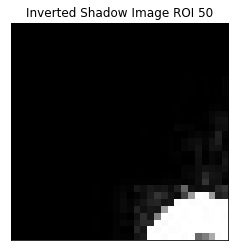

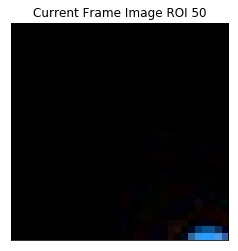

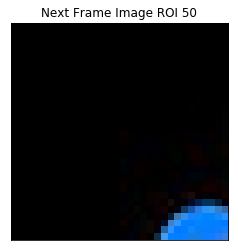

In [14]:
frame_index = 1
while True:
    img_block_str = './images/blocks/buffer/shadows/block' + str(frame_index) + '.jpg'
    while not os.path.exists(img_block_str):
        if frame_index > block_dim * block_dim:
            print('ERROR: No files found!')
            break;
        frame_index += 1
        img_block_str = './images/blocks/buffer/shadows/block' + str(frame_index) + '.jpg'
    if frame_index > block_dim * block_dim:
        print('ERROR: No files found!')
        break
    img_block_1 = cv2.cvtColor(cv2.imread(img_block_str), cv2.COLOR_BGR2RGB)
    
    # Check if image is too black, we want to show a good example.
    rejected = False
    pixel_sum = 0
    cap = np.power(block_dim, 2) * 255 * 0.95
    for y in range(0, block_dim):
        for x in range(0, block_dim):
            pixel_sum += 255 - img_block_1[y, x][0]
            if pixel_sum >= cap:
                rejected = True
                break
        if rejected:
            break
    # Store buffered frame block.
    if not rejected:
        break
    frame_index += 1
    
if frame_index <= block_dim * block_dim:
    img_block_str = './images/blocks/buffer/frames/block' + str(frame_index) + '_1.jpg'
    img_block_2 = cv2.cvtColor(cv2.imread(img_block_str), cv2.COLOR_BGR2RGB)
    img_block_str = './images/blocks/buffer/frames/block' + str(frame_index) + '_2.jpg'
    img_block_3 = cv2.cvtColor(cv2.imread(img_block_str), cv2.COLOR_BGR2RGB)

    plt.subplot(111),plt.imshow(img_block_1),plt.title('Inverted Shadow Image ROI ' + str(frame_index))
    plt.xticks([]), plt.yticks([])
    plt.show()
    plt.subplot(111),plt.imshow(img_block_2),plt.title('Current Frame Image ROI ' + str(frame_index))
    plt.xticks([]), plt.yticks([])
    plt.show()
    plt.subplot(111),plt.imshow(img_block_3),plt.title('Next Frame Image ROI ' + str(frame_index))
    plt.xticks([]), plt.yticks([])
    plt.show()

## Conclusions

#### Effective for choosing frameblocks:
  * Guaranteed minimal over-training data and maximal changes shown in training dataset
  * The next steps of this process will be to develop the Machine Learning algorithm itself
    * Run as input the frameblocks of every other frame in an animation
    * Generate frameblocks and use for training
    * Other input (i.e. the scene data) has not been decided yet

#### Rest of term:
  * Develop application:
    * Generate all frameblocks for a whole animation
    * 312 frames
    * Each frame is roughly 1024 x 512 pixels:
      * Meaning on average 256 frameblocks per frame
      * Possibly 79,872 frameblocks!
      * Good for dataset, might be hard to store!
  * Train basic Machine Learning algorithm